# Spectral Clustering Implementation and Appliacation 
### Qi Wang and Hanqiu Xia









## Abstract

Spectral clustering is widely used in image segmentation. The main idea of spectral clustering is to use the spectrum (eigenvalues) of the similarity matrix of the data to perform dimensionality reduction and then perform clustering in fewer dimensions.  In this project, we investigated the normalized spectral decomposition algorithm from the paper "On Spectral Clustering: Analysis and an algorithm" by A. Ng, M. Jordan, and Y. Weiss [1]. Their algorithm improved upon the existing spectral clustering algorithm by resolving the issues of inconsistent algorithms of using eigenvectors as well as providing evidence for a reasonable clustering. We implemented the algorithm using Python with considering both idea and special cases. We also optimized the Python codes by applying vectorization, Cython, Just-In-Time compiling and parallelization. Finally, we tested the algorithm on simulated and real datasets and compare the experimental results with those of k-means clustering to see if spectral clustering dramatically improves the results.

## 1.  Background

The research paper we chose is "On Spectral Clustering: Analysis and an algorithm" by A. Ng, M. Jordan, and Y. Weiss [1]. Spectral clustering is inspired by the the idea of spectral graph partitioning, in which we use the first two eigenvectors of a similarity matrix derived from the distance between points to partition the graph into exactly two parts. It is widely used in image segmentation. However, in previous literatures, authors are inconsistent in choosing and deriving eigenvectors. One of the achievement of A. Ng, M. Jordan, and Y. Weiss's paper is standardizing and simplifying the algorithem of spectral clustering[1]: utilising the  first $k$ largest eigenvectors to cluster points into  $k$ subsets. The detailed algorithm is as follows:

Suppose we have a set of $n$ points $S = \{ s_1, \ldots, s_n\}$ in ${\rm I\!R}^{m}$, and we want to cluster them into $k$ groups.

 **Step 1:** Construct the affinity matrix $A \in{\rm I\!R}^{n\times n} $,  each element in A is defined as $A_{ij} = exp(-||s_i-s_j||^2/2\sigma^2)$ and $A_{ii}=0$,  for $i, j = 1,\ldots, n$. 

**Step 2:** Define $D$ to be the diagonal matrix with $D_{ii} =\sum_{j=1}^{n} A _{ij}$, and form the normalized Laplacian matrix $L = D^{-1/2}AD^{-1/2}$.

**Step 3:** Capture the fist $k$ largest eigenvectors of $L, x_1, x_2,  \ldots, x_k, x_i \in {\rm I\!R}^{n} $ and form the matrix $X = [x_1 ~x_2 ~\cdots ~x_k ] \in  {\rm I\!R}^{n\times k}.$

**Step 4:** Create the new normalized matrix $Y \in {\rm I\!R}^{n\times k}$ from $X$, defined as $Y_{ij}= X_{ij}/(\sum_{j=1}^{n}X_{ij}^2)^{1/2}$.

** Step 5:** Consider $Y$ to be a set of $n$   points that need to be clustered now, apply K-means or any other algorithm that can minimize distortion to cluster $Y$. 

** Step 6:**  Assign the original point $s_i$ in to cluster $j$ if and only if the $i$th-row of $Y$ was distributed to cluster $j$  in previous step.       


Comparing to the straighforward K-means clustering, this algorithm improves the performance by normalizing affinity matrix $A$ and $X$. Especially for dataset in two-dimensional that are not correpsonding to convex region (like circular graph and moon-like graph), spectral clustering results in more reasonable clustering than K-means. We will implement this experiment in later parts.  This report is organized as follows: In part 2, we implement the spectral clustering algorithm on both idea and special cases. Next, we practice the unit test and optimize coding in part 3 and 4, respectively.  Part 5 applies the algorithm in real and simulated datasets and compare the results with k-means clustering. Part 6 draws some conclusions.





## 2. Implementation
We write four functions to implement the algorithm. The first two functions, `GenerateData` and `CreateCircle`, simluate data in idea case and special case, respectively. In the third function `CalculateAffinity`, we calculate the affinity matrix which is exactly the first step in the above described algorithm. The last function `Spectral` is the core function, which implements Step 2 to 6 in the algorithm and returns the labels for assigning each point into cluster.

### 2.1 Simulate Data
We create two functions to simulate dataset. The ideal case denotes the situation when the clusters are clearly partitioned and are far apart from each other. Our first function `GenerateData` generates data that falls under this category. 

In function `CreateCircle`, we generage data in two dimensions that not conrresponds to convex region. To be specific, we .......

We choose to show the JIT compiling code below, since this is the fastest code after optimizing. We will provide detail about the comparison among different optimization method in part 4. 

In [2]:
import random
import math
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import time

import pandas as pd
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances


import pandas as pd

- Simulate Data for Ideal Case

In [4]:
import numba
from numba import jit

In [5]:
@jit
def GenerateData_jit(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated). 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    
    # set seed if user desired
    if seed:
        random.seed(100)
    data = np.zeros((k*n,2))

    for i in range(0,k):
        for j in range(i*n,n*(i+1)):
            data[j,0] = (-2)**i + random.random()
            data[j,1] = 2**i + random.random()
  
    return data

- Simulate Data for Special Case

In [6]:
@jit
def CreateCircle_jit(n, seed = None):
    """Generate data for the case that do not correspond to convex region. 
        This function can genearate points that form circles.    

        Args:
            n: How many circles the user wants.

        Returns:
            A numpy array for the generated dataset.

    """
    if seed:
        np.random.seed(100)
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

### 2.2 Algorithm Implementation

....

- Cacluate Affinity Matrix (Step 1) 

In [7]:
@jit
def CalculateAffinity_jit(data, sigma = 0.5):
    """Create an distance matrix with the given data. This is Step 1 in the Spectral Clustering Algorithm.
    Step 1: Affinity matrix A defined by A_ij=exp(-||s_i-s_j||^2/2*sigma^2), and A_ii=0.

        Args:
            data: Data to be used to calculate Affinity.
            sigma: Standard deviation that can be chosen by user.

        Returns:
            A numpy array for the calculated affinity matrix.

    """
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity


- Spectral Clustering (Step 2-6)

In [8]:
def Spectral(k, A):
    """Create cluster labels for points from k-means using the normalized matrix Algorithm Step 2-6. 

    Step 2: Define D to be the diagonal matrix whose (i,i)-element is the sum of A's i_th
row,and construct the matrix L =D^(-l/2)AD^(-l/2).

    Step 3: Find Xl , X2 , ... , Xk, the k largest eigenvectors of L (chosen to be orthogonal to each other in the case of repeated eigenvalues), and form the matrix X = [XIX2 . . . Xk) E R^(nxk) by stacking the eigenvectors in columns.

    Step 4: Form the matrix Y from X by renormalizing each of X's rows to have unit length (i.e. Y_ij = X_ij/sum(X_ij^2)^(1/2).

    Step 5: Treating each row of Y as a point in R^k , cluster them into k clusters via K-means or any other algorithm.

    Step 6: Finally, assign the original point s_i to cluster j if and only if row i of the matrix Y was assigned to cluster j.


        Args:
            k: The number of clusters desired.
            A: The affinity matrix.

        Returns:
            A numpy array of the cluster assignment for each point.

    """
    # compute the degree matrix
    D = np.diag(np.sum(A, axis=0))


    #compute the normalized laplacian matrix
    NL1 = np.zeros((A.shape))
    for i in range(A.shape[0]):
         for j in range(A.shape[1]):
                NL1[i,j] = A[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    X = eigvector[:,sort_index[-k:][::-1]]

    
    
    #construct the normalized matrix U from the obtained eigen vectors
    Y = np.zeros((X.shape))
    for i in range(X.shape[0]):
        n = math.sqrt(sum(X[i,:]**2));   
        Y[i,:] = X[i,:]/n 

    #Apply k-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(Y)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

## 3. Unit Testing
We used pytest-ipynb to conduct unit testing. The testing file is named test*.ipynb, and by running through the file in terminal by the command py.test, the unit testing is run. All tests are passed. For each function, there are three tests to assert that each function creates data in the correct format and correct dimension to test for general cases. And by setting the seed, we can confirm that each function creates the correct matrix. For each function, there are two tests for edge cases. For the edge cases, all functions should generate an error for the incorrect inputs such as non-arrays. 

## 4. Optimization

We use vectorization, cython, Just-In-Time compiling and parallelization to optimize our code.

To eliminate the use of for loops, we vectorized to code to improve the performance. If we have a large dataset to perform clustering, the runtime will improve consistently by at least a factor of two.

We also used JIT to improve the performance, and as a result, JIT improves the runtime the most. It improved by around 20 fold.

Cython does not perform quite as well compared to the above two methods. It only improves the runtime by around a factor of 1.5.


We can see that JIT produces the best results in optimization. Thus, we will use JIT in the following applications.



In [2]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

##### GenerateDate
 - Using Vectorized 

In [4]:
def GenerateData_vectorized(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated) using vectorization. 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    # set seed if user desired
    if seed: 
        np.random.seed(seed)
    # choose to generate k datasets
    data = np.random.random((k*n,2))
    for i in range(0,k):
        data[i*n:n*(i+1),0] += (-2)**i
        data[i*n:n*(i+1),1] += 2**i

    return data

- Using JIT

In [5]:
import numba
from numba import jit

In [6]:
@jit
def GenerateData_jit(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated). 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    
    # set seed if user desired
    if seed:
        random.seed(100)
    data = np.zeros((k*n,2))

    for i in range(0,k):
        for j in range(i*n,n*(i+1)):
            data[j,0] = (-2)**i + random.random()
            data[j,1] = 2**i + random.random()
  
    return data

- Using Cython

In [8]:
%load_ext cython

In [9]:
%%cython -a

import cython
import numpy as np
import random

@cython.boundscheck(False)
@cython.wraparound(False)
def GenerateData_cython(k, n = 20, seed=None):
    """Generate data for the ideal case (clusters well separated). 
        This function can genearate k numbers of clusters. Each cluster has n points.    

        Args:
            k: Number of clusters
            n: Number of points in each cluster
            seed: Set seed for the random number generators.

        Returns:
            A numpy array for the generated dataset.

    """
    
    # set seed if user desired
    if seed:
        random.seed(100)
    data = np.zeros((k*n,2))

    for i in range(0,k):
        for j in range(i*n,n*(i+1)):
            data[j,0] = (-2)**i + random.random()
            data[j,1] = 2**i + random.random()
  
    return data

- Using Multi-processing

In [11]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import time
start = time.clock()
res1 = GenerateData(3)
time1 = time.clock()-start

In [12]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(GenerateData, 3)
time2 = time.clock() - start

#### Speed-up ratio (Generate Data)

In [13]:
k = 3
report([GenerateData,GenerateData_vectorized],k)

GenerateData: 1.0
GenerateData_vectorized: 0.2


In [14]:
report([GenerateData,GenerateData_jit],k)

GenerateData: 1.0
GenerateData_jit: 0.0


In [16]:
report([GenerateData,GenerateData_cython],k)

GenerateData: 1.0
GenerateData_cython: 1.3


In [18]:
# Multi-processing
time1/time2

0.006234564182882655

##### Create Non-Convex Region data 


- Using Vectorization

In [20]:
def CreateCircle_vectorized(n, seed = None):
    """Generate data for the case that do not correspond to convex region. 
        This function can genearate points that form circles.    

        Args:
            n: How many circles the user wants.

        Returns:
            A numpy array for the generated dataset.

    """
    if seed:
        np.random.seed(100)
    # generate a center for circles
    u=n*np.random.random()
    # generate an array of radius
    d= np.linspace(1,5*n,n)
    # generate an array of positions where the circles cross the x axis
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        # an array of positions on x axis      
        x=np.linspace(-r[i],r[i],100)
        # corresponding y axis > 0for the circle
        y=np.sqrt(r[i]**2-x**2)
        # corresponding y axis < 0for the circle
        y2=-np.sqrt(r[i]**2-x**2)
        c1 = 2*i*100
        c2 = (2*i+1)*100
        c3 = (2*i+2)*100
        df[c1:c2,0] = x
        df[c1:c2,1] = y
        df[c2:c3,0] = x
        df[c2:c3,1] = y2

    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

- Using JIT

In [21]:
@jit
def CreateCircle_jit(n, seed = None):
    """Generate data for the case that do not correspond to convex region. 
        This function can genearate points that form circles.    

        Args:
            n: How many circles the user wants.

        Returns:
            A numpy array for the generated dataset.

    """
    if seed:
        np.random.seed(100)
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df

- Using Cython

In [22]:
%%cython -a

import cython
import numpy as np
import random


@cython.boundscheck(False)
@cython.wraparound(False)

def CreateCircle_cython(n, seed = None):
    """Generate data for the case that do not correspond to convex region. 
        This function can genearate points that form circles.    

        Args:
            n: How many circles the user wants.

        Returns:
            A numpy array for the generated dataset.

    """
    if seed:
        np.random.seed(100)
    u=n*np.random.random()
    d= np.linspace(1,5*n,n)
    r=u+d
    
    df=np.zeros((n*200,2))
    for i in range(n):
        
        x=np.linspace(-r[i],r[i],100)
        y=np.sqrt(r[i]**2-x**2)
        y2=-np.sqrt(r[i]**2-x**2)
        for j in range(2*i*100,(2*i+1)*100):
            df[j,0]=x[j-2*i*100]
            df[j,1]=y[j-2*i*100]
        for j in range((2*i+1)*100,(2*i+2)*100):
            df[j,0]=x[j-(2*i+1)*100]
            df[j,1]=y2[j-(2*i+1)*100]
    
    #Add noise
    df = df + np.random.random((n*200,2))
    
    return df


- Using Multi-processing

In [23]:
start = time.clock()
cir1 = CreateCircle(2)
time1 = time.clock()-start

In [24]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(CreateCircle, 2)
time2 = time.clock() - start



#### Speed-up Ratio( Create Circular Data )

In [25]:
n = 3
report([CreateCircle,CreateCircle_vectorized], n)

CreateCircle: 1.0
CreateCircle_vectorized: 0.8


In [26]:
report([CreateCircle,CreateCircle_jit],n)

CreateCircle: 1.0
CreateCircle_jit: 0.0


In [27]:
report([CreateCircle,CreateCircle_cython],n)

CreateCircle: 1.0
CreateCircle_cython: 1.0


In [28]:
##Multi-processing
time1/time2

0.07271915361363619

##### Calculate Affinity


- Using Vectorized

In [30]:
from sklearn.metrics.pairwise import euclidean_distances
def CalculateAffinity_vectorized(data, sigma = 0.5):
    """Create an distance matrix with the given data. This is Step 1 in the Spectral Clustering Algorithm.
    Step 1: Affinity matrix A defined by A_ij=exp(-||s_i-s_j||^2/2*sigma^2), and A_ii=0.

        Args:
            data: Data to be used to calculate Affinity.
            sigma: Standard deviation that can be chosen by user.

        Returns:
            A numpy array for the calculated affinity matrix.

    """
    # find the euclidean distance for the data
    distance = euclidean_distances(data, data)
    # calculate the affinity matrix A_ij=exp(-||s_i-s_j||^2/2*sigma^2)
    affinity = np.exp(-distance/(2*sigma**2))
    # A_ii=0
    A = (np.ones(affinity.shape) - np.eye(affinity.shape[0]))*affinity
    
    return A
    

- Using JIT

In [31]:
@jit
def CalculateAffinity_jit(data, sigma = 0.5):
    """Create an distance matrix with the given data. This is Step 1 in the Spectral Clustering Algorithm.
    Step 1: Affinity matrix A defined by A_ij=exp(-||s_i-s_j||^2/2*sigma^2), and A_ii=0.

        Args:
            data: Data to be used to calculate Affinity.
            sigma: Standard deviation that can be chosen by user.

        Returns:
            A numpy array for the calculated affinity matrix.

    """
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity


- Using Cython

In [33]:
%%cython -a

import cython
import numpy as np
import random
import math

@cython.boundscheck(False)
@cython.wraparound(False)
def CalculateAffinity_cython(data, sigma = 0.5):
    col_size = data.shape[0]
    dim = data.shape[1]
    affinity = np.zeros((col_size,col_size))

    for i in range(col_size):
        for j in range(col_size):
            dist_tmp = 0
            for k in range(dim):
                dist_tmp +=(data[i,k]-data[j,k])**2
            dist = math.sqrt(dist_tmp)
            affinity[i,j] = math.exp(-dist/(2*sigma**2))
    return affinity

- Using Multi-processing

In [36]:
data = GenerateData(3)
start = time.clock()
aff1 = CalculateAffinity(data)
time1 = time.clock()-start

In [37]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(CalculateAffinity, data)
time2 = time.clock() - start

#### Speed-up Ratio (Calculate Affinity )

In [38]:
data = GenerateData(3)

In [39]:
report([CalculateAffinity,CalculateAffinity_vectorized],data)

CalculateAffinity: 1.0
CalculateAffinity_vectorized: 0.3


In [40]:
report([CalculateAffinity,CalculateAffinity_jit],data)

CalculateAffinity: 1.0
CalculateAffinity_jit: 0.1


In [42]:
report([CalculateAffinity,CalculateAffinity_cython],data)

CalculateAffinity: 1.0
CalculateAffinity_cython: 1.3


In [44]:
##Multi-processing
time1/time2

0.4707997786930458

##### Spectral Clustering


- Using JIT

In [46]:
@jit
def Spectral_jit(k,A):
    # compute the degree matrix
    D = np.diag(np.sum(A, axis=0))


    #compute the normalized laplacian matrix
    NL1 = np.zeros((A.shape))
    for i in range(A.shape[0]):
         for j in range(A.shape[1]):
                NL1[i,j] = A[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    X = eigvector[:,sort_index[-k:][::-1]]

    
    
    #construct the normalized matrix U from the obtained eigen vectors
    Y = np.zeros((X.shape))
    for i in range(X.shape[0]):
        n = math.sqrt(sum(X[i,:]**2));   
        Y[i,:] = X[i,:]/n 

    #Apply k-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(Y)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

- Using Cython

In [47]:
%%cython -a

import cython
import numpy as np
import random
import math
import scipy.linalg as la
from sklearn.cluster import KMeans

@cython.boundscheck(False)
@cython.wraparound(False)


def Spectral_cython(k,A):
    # compute the degree matrix
    
    D = np.diag(np.sum(A, axis=0))


    #compute the normalized laplacian matrix
    NL1 = np.zeros((A.shape))
    for i in range(A.shape[0]):
         for j in range(A.shape[1]):
                NL1[i,j] = A[i,j]/(math.sqrt(D[i,i])*math.sqrt(D[j,j]))

    eigvalue,eigvector = la.eig(NL1)
    sort_index = np.argsort(eigvalue)
    X = eigvector[:,sort_index[-k:][::-1]]

    
    
    #construct the normalized matrix U from the obtained eigen vectors
    Y = np.zeros((X.shape))
    for i in range(X.shape[0]):
        n = math.sqrt(sum(X[i,:]**2));   
        Y[i,:] = X[i,:]/n 

    #Apply k-means
    clust_result = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clust_result.fit_predict(Y)
    indicator=np.loadtxt(cluster_labels,dtype='int32')
    ID=indicator.tolist()
    IDX=np.asarray(ID) 
    return IDX

- Using Multi-processing 

In [48]:
start = time.clock()
spec = Spectral(3,aff1)
time1 = time.clock()-start

In [49]:
start = time.clock()
with ProcessPoolExecutor(max_workers=4) as pool:
    res = pool.submit(Spectral, 3, aff1)
time2 = time.clock() - start

In [50]:
res.result

<bound method Future.result of <Future at 0x11aa61a58 state=finished returned ndarray>>

#### Speed-up Ratio (Spectral Clustering)

In [51]:
k = 3
data = GenerateData(k)
affinity = CalculateAffinity(data)

In [52]:
report([Spectral,Spectral_cython],k,affinity)

Spectral: 1.0
Spectral_cython: 1.0


In [55]:
report([Spectral,Spectral_jit],k,affinity)

Spectral: 1.0
Spectral_jit: 1.2


In [56]:
#Multi-processing 
time1/time2

1.4737164375593552

The table below summarizes the speed-up ratios for different optimization methods for each function.

In [1]:
import pandas as pd
t1 = pd.read_csv('/Users/apple/Desktop/opt.csv',)
t1.head()

,Function,Vectorization,JIT,Cython,Parallelization
0,GenerateData,0,0,0,0
1,CreateCircle,1,1,1,1
2,CalculateAffinity,2,2,2,2
3,Spectral,3,3,3,3


## 5. Application and Comparison
### 5.1 Ideal Case

In [9]:
data = GenerateData_jit(3)
affinity = CalculateAffinity_jit(data)

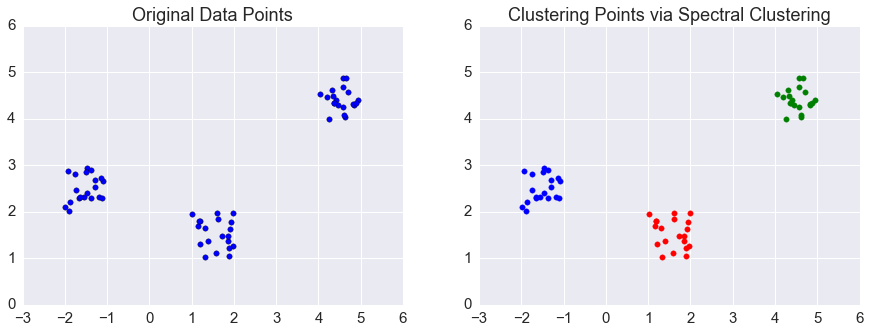

In [11]:
IDX= Spectral(3,affinity)

# Draw graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Spectral Clustering')
plt.show()





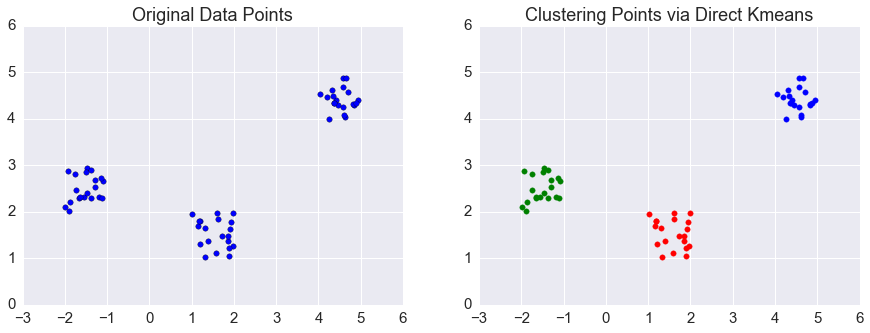

In [12]:
k=3
X=data

# Apply K-means
clust_result = KMeans(n_clusters=k, random_state=10)
cluster_labels = clust_result.fit_predict(X)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Direct Kmeans')
plt.show()





### 5.2 Special Case

In [13]:
k=3
data = CreateCircle_jit(3)
affinity = CalculateAffinity_jit(data)

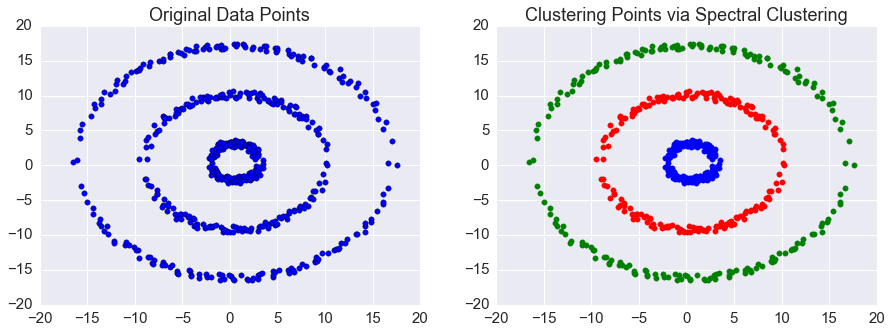

In [14]:
IDX= Spectral(k,affinity)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
         plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Spectral Clustering')
plt.show()




- Compare with K-means

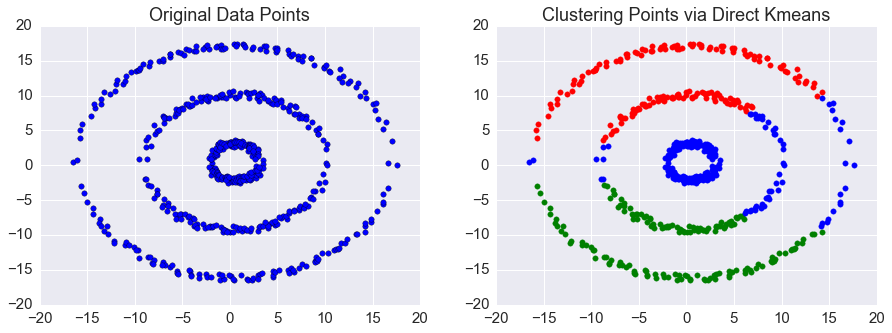

In [15]:
X=data

# Apply K-means directly
clust_result = KMeans(n_clusters=3, random_state=10)
cluster_labels = clust_result.fit_predict(X)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
    elif IDX[i] == 2:
        plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Direct Kmeans')
plt.show()




### 5.3 Real Dataset

In [63]:
a = np.loadtxt('jain.txt')

In [64]:
data = a[:,0:2]
affinity = CalculateAffinity_jit(data)
k = 2

In [ ]:
IDX=Spectral_jit(k,affinity)

# Draw graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
#     elif IDX[i] == 2:
#         plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Spectral Clustering')
plt.show()

- Compare with K-means

In [ ]:
# Apply k-means
clust_result = KMeans(n_clusters=k, random_state=10)
cluster_labels = clust_result.fit_predict(data)
indicator=np.loadtxt(cluster_labels,dtype='int32')
ID=indicator.tolist()
IDX=np.asarray(ID) 


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(data[:,0],data[:,1],s=30)
plt.title('Original Data Points')

plt.subplot(1,2,2)
for i in range(len(IDX)):
    if IDX[i] == 0:
        plt.scatter(data[i,0],data[i,1],color='red',s=30)
    elif IDX[i] == 1:
        plt.scatter(data[i,0],data[i,1],color = 'blue',s=30)
#     elif IDX[i] == 2:
#         plt.scatter(data[i,0],data[i,1],color = 'green',s=30)
plt.title('Clustering Points via Direct Kmeans')
plt.show()

## 6. Conclusion

## References

[1] A. Ng, M. Jordan, and Y. Weiss. On Spectral Clustering: Analysis and an algorithm. Advances in Neural Information Processing. Vol. 14, No. 2. (2001), pp. 849-856